In [0]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [0]:
url = "https://drive.google.com/uc?export=download&id=1_-YYNO3LxnaWVtqySlyZ3CSzrQKsaIEF"
irl_test = "https://drive.google.com/uc?export=download&id=1_-YYNO3LxnaWVtqySlyZ3CSzrQKsaIEF"
df = pd.read_csv(url)

test = pd.read_csv(url)

In [3]:
#shape of dataset
df.shape


(10886, 12)

In [4]:
#sample of data
df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [5]:
#variable types
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Feature Engineering


In [0]:
#creating new columns from date time column

df['date'] = df.datetime.apply(lambda x : x.split()[0])

df['hour'] = df.datetime.apply(lambda x: x.split()[1].split(":")[0])

df['weekday'] = df.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

df['month'] = df.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

df['season'] = df.season.map({1:'Spring',2:'Summer',3:'Fall',4:'Winter'})

df['weather'] = df.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })






In [0]:
#converting datatype to categorical

categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    df[var] = df[var].astype("category")


In [8]:
df.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
hour          category
weekday       category
month         category
dtype: object

In [0]:
#dropping unnecessary columns

df = df.drop(['datetime'], axis=1)

In [10]:
df.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January


### **Visualizing variable data type count**

In [11]:
df_dtype = pd.DataFrame(df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})

fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=df_dtype,x="variableType",y="count",ax=ax)
#ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


TypeError: ignored

TypeError: ignored

<Figure size 864x360 with 1 Axes>

In [0]:
df_dtype

In [0]:
msno.matrix(df,figsize=(12,5))

### **Outlier Analysis**

In [0]:
fig, axes  = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12,10)

sn.boxplot(df, y = 'count', orient = 'v', ax = axes[0][0])
sn.boxplot(data=df,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=df,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel = 'Count', title = 'Box Plot on Count')
axes[0][1].set(title = 'Box plot across Season')
axes[1][0].set(title = 'Box plot across hour')
axes[1][1].set(title = 'Box plot across Workingday')

### **Removing Outliers**

In [0]:
df_no_out = df[np.abs(df['count'] - df['count'].mean()) <= 3* df['count'].std()]

In [0]:
print('original dataframe: ', df.shape)
print('data frame after removing outliers: ',df_no_out.shape)

### **Correlation analysis**

In [0]:
corr_mat= df[['temp','atemp','humidity','windspeed','casual','registered','count']].corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)]=False
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
sn.heatmap(corr_mat, mask = mask, vmax = 0.8, square = True, annot = True)

 -  temp has positive correlation with count
 - humidity has negative correlation with count
 - windshpeed has very low correlation and hence not going to be that useful
 - atemp and temp have a very high correlation. We can drop one of the variable during model building to prevent curse of dimensionality
 - casual and registerd are not taken into account since they are leakage variables.

In [0]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(10,5)
sn.regplot(x='temp',y='count', data = df, ax=ax1)
sn.regplot(x ='humidity', y = 'count', data = df, ax = ax2)
sn.regplot(x='windspeed',y='count', data = df, ax = ax3)

### **Visualizing distribution of data**

the data from count is skewed to the right. Even after taking log transformation of the data without log transformation, it distribution is a lot better, but still doest follow the ideal normal distribution.

In [0]:
fig, axes= plt.subplots(ncols = 2, nrows = 2)
fig.set_size_inches(12, 8)
sn.distplot(df['count'], ax = axes[0][0])
stats.probplot(df['count'],dist = 'norm', fit = True, plot = axes[0][1])
sn.distplot(np.log(df_no_out['count']), ax = axes[1][0])
stats.probplot(np.log1p(df_no_out['count']),dist = 'norm', fit = True, plot = axes[1][1])



### **Visualzing count vs month, day, hour, season, usertype**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


[Text(0, 0.5, 'Average Count'),
 Text(0.5, 0, 'Hour of the Day'),
 Text(0.5, 1.0, 'Average count by Hours per Day with respect to User Type')]

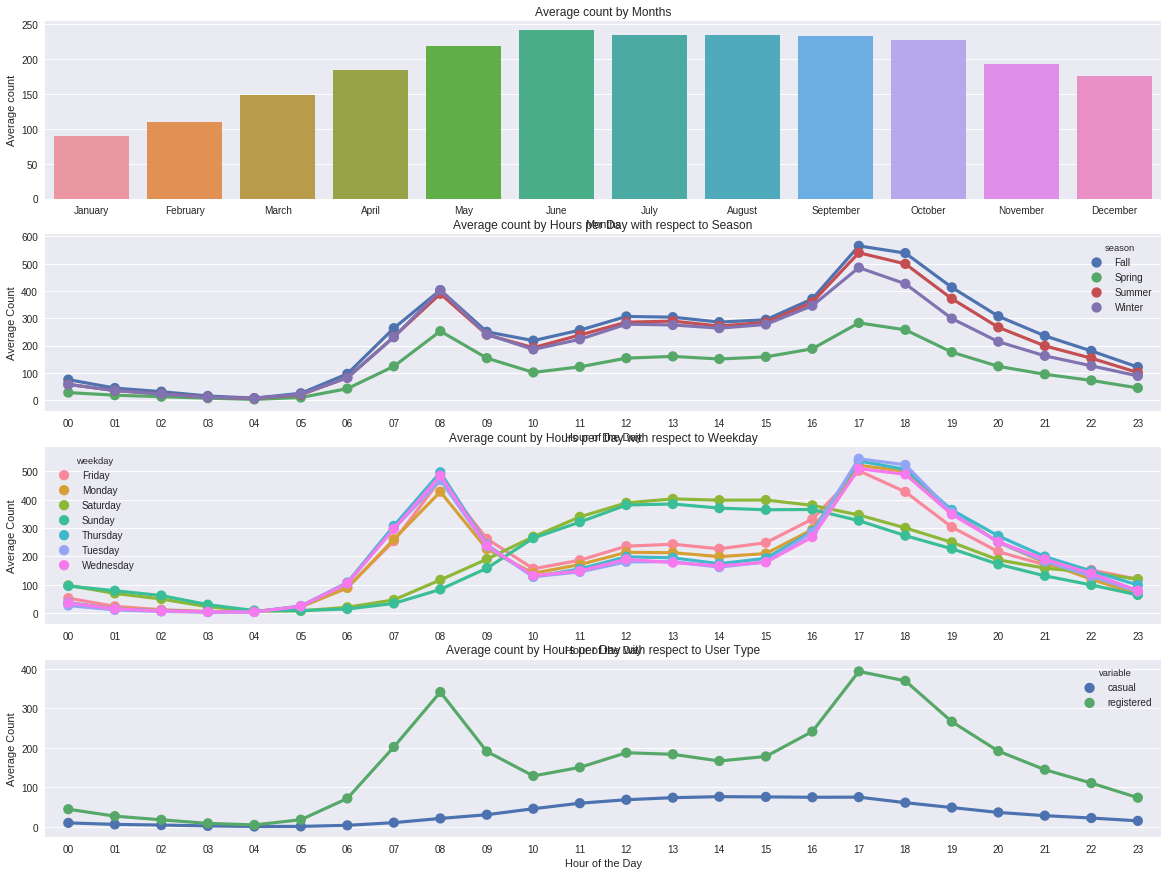

In [12]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4)
fig.set_size_inches(20,15)
order_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ]
hue_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Friday', 'Saturday']


#avg count by months
month_agg = pd.DataFrame(df.groupby('month')['count'].mean()).reset_index()
sn.barplot(data = month_agg,x = 'month',y = 'count', ax = ax1, order = order_month)
ax1.set(xlabel = 'Months', ylabel = 'Average count', title = 'Average count by Months')

#avg count by hours with respect to season
hr_agg = pd.DataFrame(df.groupby(['hour', 'season'])['count'].mean()).reset_index()
sn.pointplot(data = hr_agg, x = hr_agg['hour'], y = hr_agg['count'],hue = hr_agg['season'], join = True, ax = ax2 )
ax2.set(xlabel = 'Hour of the Day', ylabel = 'Average Count', title = 'Average count by Hours per Day with respect to Season')

#avg count by hours with repect to weekdays
hr_week = pd.DataFrame(df.groupby(['hour','weekday'])['count'].mean()).reset_index()
sn.pointplot(data = hr_week, x = hr_week['hour'], y = hr_week['count'], ax = ax3, hue = hr_week['weekday'], join = True)
ax3.set(xlabel = 'Hour of the Day', ylabel = 'Average Count', title = 'Average count by Hours per Day with respect to Weekday')

#avg count by hour with respect to user type
hr_trans = pd.melt(df[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hr_user = pd.DataFrame(hr_trans.groupby(['hour','variable'],sort =True)['value'].mean()).reset_index()
sn.pointplot(data = hr_user, x = hr_user['hour'], y = hr_user['value'],hue = hr_user['variable'], join = True, ax = ax4 )
ax4.set(xlabel = 'Hour of the Day', ylabel = 'Average Count', title = 'Average count by Hours per Day with respect to User Type')

### **Building model**

In [0]:
#read training and test data
url = "https://drive.google.com/uc?export=download&id=1_-YYNO3LxnaWVtqySlyZ3CSzrQKsaIEF"
url_test = "https://drive.google.com/uc?export=download&id=1_-YYNO3LxnaWVtqySlyZ3CSzrQKsaIEF"

train = pd.read_csv(url)
test = pd.read_csv(url_test)





### **Feature Engineering**

In [0]:
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [0]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [0]:
#coercing datatype to categorical from object 
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"datetime","date","registered", 'count']

for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")
    

In [0]:
#splitting data
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [0]:
#droping unwanted columns
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

In [0]:
#rmse scorer
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### **Linear Regression**

In [155]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.9778188829547161


### **Random Forest**

In [159]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.040904095365262384


### **Gradient Boost**

In [160]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.1944927958392613
